In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

while 'notebooks' in os.getcwd():
    os.chdir('..')

import torch
import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from sklearn.metrics import roc_auc_score
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import numpy as np
import pandas as pd

from src.torch_geo_models import DotMLPRelu
from src.data.gamma.structural_arxiv import load_dataset, get_train_val_test_edges, prepare_adjencency, get_edge_index_from_adjencency
from src.train.structural_omega.mlp import StructuralOmegaMLP

/home/caiolmartinelli/.cache/pypoetry/virtualenvs/arxiv-paperclassification-f16XUvnj-py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
logging.basicConfig(
    format='%(asctime)s - %(levelname)s : %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    filename='logs/omega_function/02-1-structural_mlp_gamma_function.log'
)

In [4]:
dataset_name = 'ogbn-arxiv'

In [5]:
torch.cuda.is_available()

True

In [6]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
device

device(type='cuda', index=0)

## Data Loading

In [6]:
dataset = load_dataset()

In [7]:
data, edges_train, edges_val, edges_test = get_train_val_test_edges(dataset, device=device)

In [8]:
data = prepare_adjencency(data)

## Training

In [9]:
for run in range(30):
    for n_layers in range(1, 6):
        omega = StructuralOmegaMLP(device, n_layers=n_layers, run=run)
        torch.cuda.empty_cache()
        omega.train(edges_train,
                    edges_val,
                    edges_test,
                    data.x,
                    data.y)

## Results

### For a Layer Number

In [8]:
n_layers = 3

In [9]:
metrics = StructuralOmegaMLP.read_metrics(dataset='ogbn-arxiv', n_layers=n_layers)
print(metrics.shape)
metrics.head()

(1530, 8)


,run,epoch,loss_train,loss_val,loss_test,auc_train,auc_val,auc_test
0,0,0,0.711921,0.708201,0.707602,0.417311,0.436905,0.447820
1,0,100,0.563181,0.595271,0.613246,0.709775,0.696999,0.665045
2,0,200,0.545506,0.580902,0.603995,0.734617,0.716961,0.683724
3,0,300,0.536791,0.575919,0.600728,0.746395,0.722850,0.688986
4,0,400,0.531787,0.574041,0.599886,0.752899,0.725031,0.690482


### Sumarize metrics per epoch

In [10]:
metrics_cols = metrics.columns[2:]
metrics_cols

Index(['loss_train', 'loss_val', 'loss_test', 'auc_train', 'auc_val',
       'auc_test'],
      dtype='object')

In [11]:
metrics['loss_train'] = metrics\
    .replace('None', np.nan)\
    ['loss_train']\
    .astype(float)

In [12]:
epoch_metrics = metrics\
    .fillna(-1)\
    .groupby('epoch')\
    [metrics_cols]\
    .agg(['mean', 'std'])
epoch_metrics.columns = [f'{x[0]}_{x[1]}' for x in epoch_metrics.columns]
epoch_metrics.head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
0,0.699879,0.009989,0.698596,0.008041,0.698395,0.007725,0.498615,0.030037,0.501891,0.026445,0.502319,0.024996
100,0.560307,0.002376,0.592036,0.002079,0.611683,0.001462,0.712275,0.003575,0.700206,0.003163,0.668368,0.003056
200,0.541821,0.002472,0.578451,0.001586,0.602491,0.001145,0.740053,0.003637,0.720061,0.002139,0.686119,0.001906
300,0.532377,0.003076,0.573547,0.001965,0.599144,0.001574,0.753241,0.004289,0.726276,0.002483,0.691585,0.002349
400,0.526575,0.003610,0.571073,0.002159,0.597408,0.001610,0.760808,0.004787,0.729150,0.002685,0.694078,0.002460


In [13]:
epoch_metrics.sort_values('auc_val_mean', ascending=False).head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
1400,0.508406,0.003802,0.567125,0.002815,0.595385,0.003015,0.786430,0.004693,0.734971,0.002214,0.698447,0.001908
1500,0.507821,0.003899,0.567643,0.003457,0.595960,0.003522,0.787378,0.004671,0.734967,0.002215,0.698370,0.001926
1300,0.509010,0.003869,0.566811,0.002586,0.594890,0.002302,0.785337,0.004689,0.734961,0.002205,0.698485,0.001907
1200,0.509744,0.003760,0.566624,0.002397,0.594518,0.001963,0.784063,0.004642,0.734905,0.002177,0.698525,0.001910
1600,0.507346,0.003847,0.568239,0.003813,0.596687,0.004172,0.788314,0.004671,0.734861,0.002145,0.698270,0.001832


/tmp/ipykernel_35385/1953291945.py:8: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/tmp/ipykernel_35385/1953291945.py:9: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/tmp/ipykernel_35385/1953291945.py:56: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavio

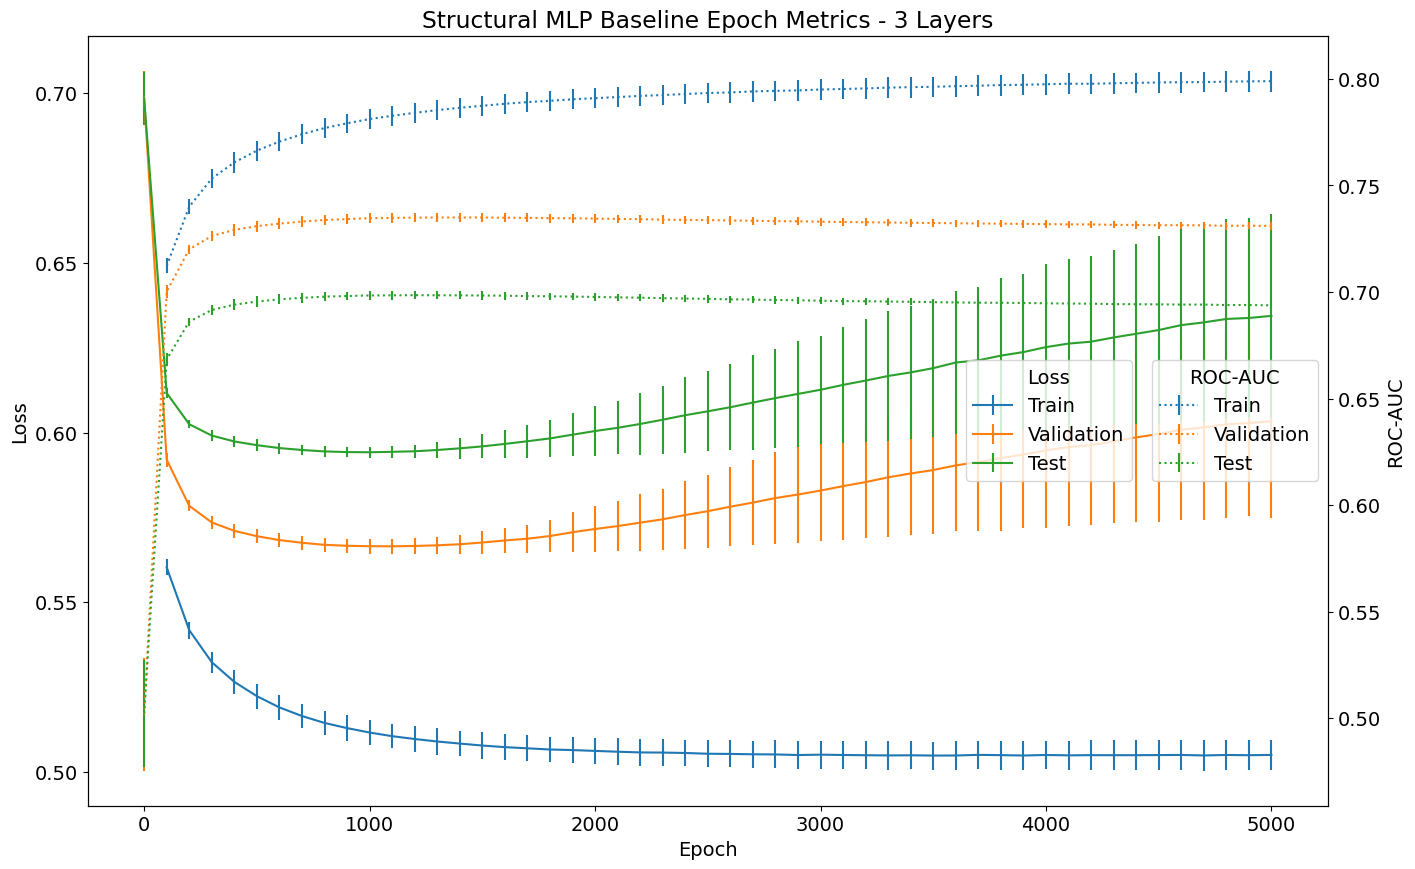

In [14]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title(f'Structural MLP Baseline Epoch Metrics - {n_layers} Layers')

ax1.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['loss_train_mean'][1:],
    yerr=epoch_metrics['loss_train_std'][1:],
    ls='-',
    label='Train')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_val_mean'],
    yerr=epoch_metrics['loss_val_std'],
    ls='-',
    label='Validation')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_test_mean'],
    yerr=epoch_metrics['loss_test_std'],
    ls='-',
    label='Test')

# ax1.plot(
#     epoch_metrics.index[1:],
#     epoch_metrics['loss_train_mean'][1:],
#     # yerr=epoch_metrics['loss_train_std'][1:],
#     ls='-',
#     label='Train')

# ax1.plot(
#     epoch_metrics.index,
#     epoch_metrics['loss_val_mean'],
#     # yerr=epoch_metrics['loss_val_std'],
#     ls='-',
#     label='Validation')

# ax1.plot(
#     epoch_metrics.index,
#     epoch_metrics['loss_test_mean'],
#     # yerr=epoch_metrics['loss_test_std'],
#     ls='-',
#     label='Test')

ax1.legend(loc='center right', title='Loss', bbox_to_anchor=[0.85, 0.5])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')

ax2 = ax1.twinx()

ax2.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['auc_train_mean'][1:],
    yerr=epoch_metrics['auc_train_std'][1:],
    ls=':',
    label='Train')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_val_mean'],
    yerr=epoch_metrics['auc_val_std'],
    ls=':',
    label='Validation')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_test_mean'],
    yerr=epoch_metrics['auc_test_std'],
    ls=':',
    label='Test')

# ax2.plot(
#     epoch_metrics.index[1:],
#     epoch_metrics['auc_train_mean'][1:],
#     # yerr=epoch_metrics['auc_train_std'][1:],
#     ls=':',
#     label='Train')

# ax2.plot(
#     epoch_metrics.index,
#     epoch_metrics['auc_val_mean'],
#     # yerr=epoch_metrics['auc_val_std'],
#     ls=':',
#     label='Validation')

# ax2.plot(
#     epoch_metrics.index,
#     epoch_metrics['auc_test_mean'],
#     # yerr=epoch_metrics['auc_test_std'],
#     ls=':',
#     label='Test')

ax2.legend(loc='center right', title='ROC-AUC', bbox_to_anchor=[1, 0.5])
ax2.set_ylabel('ROC-AUC')

plt.savefig(f'reports/images/structural_omega_dotmlp_training_metrics_{n_layers}layers.pdf')

### Comparing Validation Performance for All Layer numbers

In [15]:
n_layers_list = range(1, 6)

In [16]:
mean_auc_val_dict = {}
mean_loss_val_dict = {}
std_auc_val_dict = {}
std_loss_val_dict = {}
for n_layers in n_layers_list:
    metrics = StructuralOmegaMLP.read_metrics(dataset=dataset_name, n_layers=n_layers)
    mean_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].mean()
    
    auc_val = mean_df['auc_val']
    loss_val = mean_df['loss_val']
    mean_auc_val_dict[n_layers] = auc_val
    mean_loss_val_dict[n_layers] = loss_val

    std_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].std()

    auc_val = std_df['auc_val']
    loss_val = std_df['loss_val']
    std_auc_val_dict[n_layers] = auc_val
    std_loss_val_dict[n_layers] = loss_val

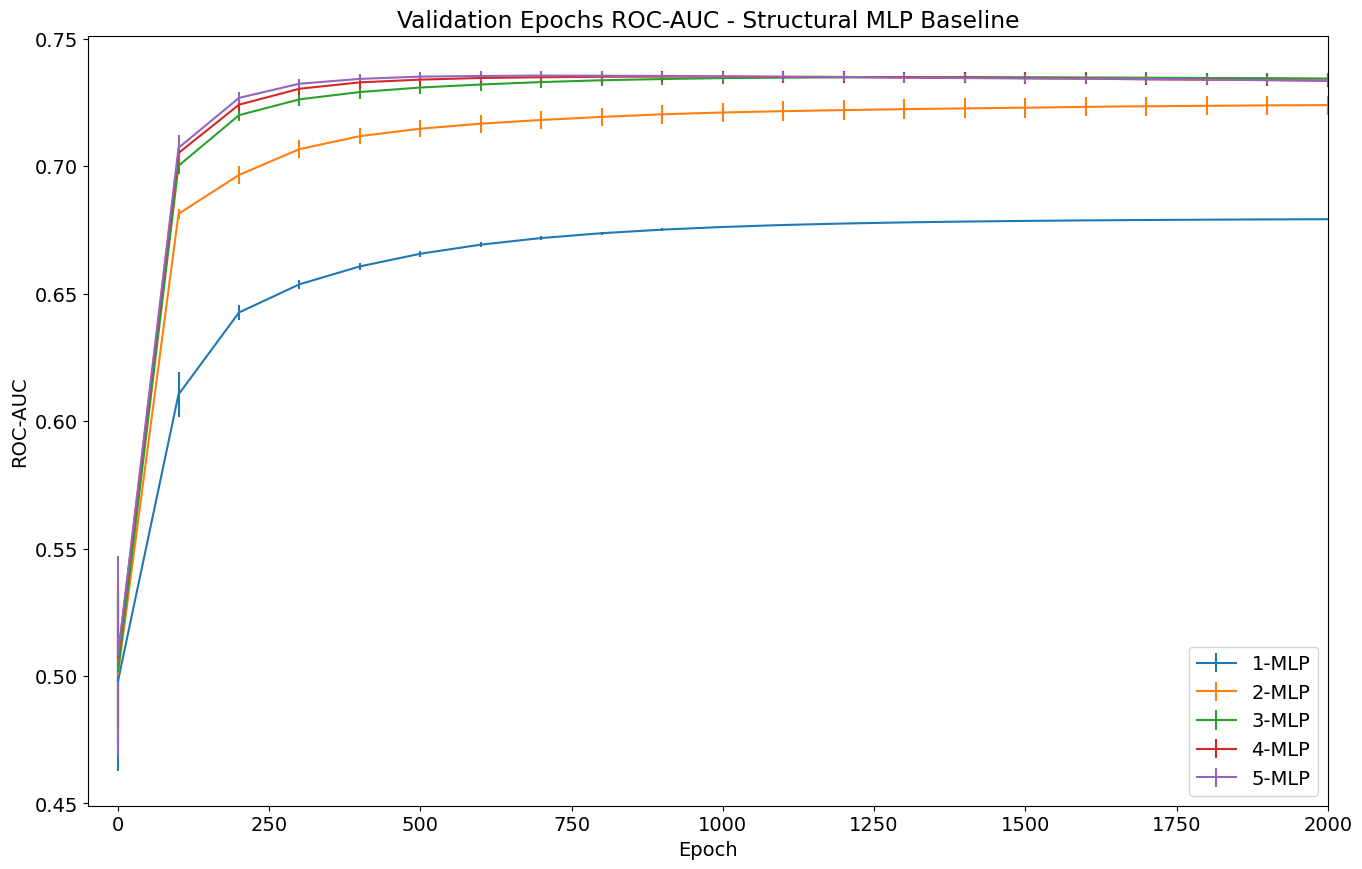

In [17]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title('Validation Epochs ROC-AUC - Structural MLP Baseline')

for n_layers in mean_auc_val_dict:
    ax1.errorbar(
        mean_auc_val_dict[n_layers].index,
        mean_auc_val_dict[n_layers],
        yerr=std_auc_val_dict[n_layers],
        ls='-',
        label=f'{n_layers}-MLP')

ax1.set_xlim(-50, 2000)

ax1.legend()

ax1.set_xlabel('Epoch')
ax1.set_ylabel('ROC-AUC')

plt.savefig(f'reports/images/{dataset_name}/structural_omega_dotmlp_training_metrics_multilayer_validation.pdf')

## Score Best model

In [18]:
best_model_metrics = metrics.sort_values('auc_val', ascending=False).iloc[0]
best_model_metrics

run            10.000000
epoch         700.000000
loss_train      0.502020
loss_val        0.562960
loss_test       0.591469
auc_train       0.797208
auc_val         0.740242
auc_test        0.703075
Name: 517, dtype: float64

In [19]:
best_model_metrics.to_json(f'models/structural_omega_mlp/{dataset_name}/best_model_info.json')

### Load data

In [20]:
dataset = load_dataset()

data, edges_train, edges_val, edges_test = get_train_val_test_edges(
    dataset=dataset, device=device
)

data = prepare_adjencency(data, to_symmetric=True)

edge_index = get_edge_index_from_adjencency(data, device)

### Load model

In [21]:
data.num_nodes

169343

In [22]:
omega = StructuralOmegaMLP.load_model(
    dataset=dataset_name,
    run=int(best_model_metrics['run']),
    epoch=int(best_model_metrics['epoch']),
    device=device,
    num_nodes=data.num_nodes,
    n_layers=5,
    batch_size=1024)

In [23]:
dataset

PygNodePropPredDataset()

### Score model

In [24]:
dataset = load_dataset()
data = prepare_adjencency(dataset[0], to_symmetric=True).to(device)

edge_index = get_edge_index_from_adjencency(data, device)

In [25]:
edge_index

tensor([[   411,    640,   1162,  ..., 163274,  27824, 158981],
        [     0,      0,      0,  ..., 169341, 169342, 169342]],
       device='cuda:0')

In [26]:
edges_train

tensor([[104447,  15858, 107156,  ...,   1326, 129609,  26457],
        [ 13091,  47283,  69161,  ...,  55379, 158430,  54167]],
       device='cuda:0')

In [28]:
preds_train = omega.forward(edges_train, data.x).to('cpu').detach().numpy()
preds_train[:5]

array([[0.5869558 ],
       [0.6419196 ],
       [0.35204935],
       [0.34115332],
       [0.2977468 ]], dtype=float32)

In [29]:
preds_val = omega.forward(edges_val, data.x).to('cpu').detach().numpy()
preds_val[:5]

array([[0.678504  ],
       [0.57322884],
       [0.36717904],
       [0.45000094],
       [0.63664293]], dtype=float32)

In [30]:
preds_test = omega.forward(edges_test, data.x).to('cpu').detach().numpy()
preds_test[:5]

array([[0.5654791 ],
       [0.58512646],
       [0.5295948 ],
       [0.48839432],
       [0.6740759 ]], dtype=float32)

In [37]:
preds = np.concatenate([preds_train, preds_val, preds_test])

In [44]:
edges = torch.concat([edges_train, edges_val, edges_test], dim=1)
edges

tensor([[104447,  15858, 107156,  ...,  45118,  45118,  45118],
        [ 13091,  47283,  69161,  ..., 162473, 162537,  72717]],
       device='cuda:0')

In [47]:
theta = omega.is_same_class(edges, data.y).to('cpu').detach().numpy()

In [50]:
roc_auc_score(theta, preds)

0.7418171182967898

In [51]:
theta.mean()

0.655083031580897

### Save output

In [52]:
cpu_edges = edges.to('cpu').numpy()
edges_omega_df = pd.DataFrame({
    'source': cpu_edges[0],
    'target': cpu_edges[1],
    'omega_pred': preds[:,0]
})
print(edges_omega_df.shape)
edges_omega_df.head()

(1166243, 3)


,source,target,omega_pred
0,104447,13091,0.586956
1,15858,47283,0.641920
2,107156,69161,0.352049
3,107156,136440,0.341153
4,107156,107366,0.297747


In [54]:
edges_omega_df.to_csv(f'data/scored_omega/{dataset_name}/structural_mlp.csv', index=False)

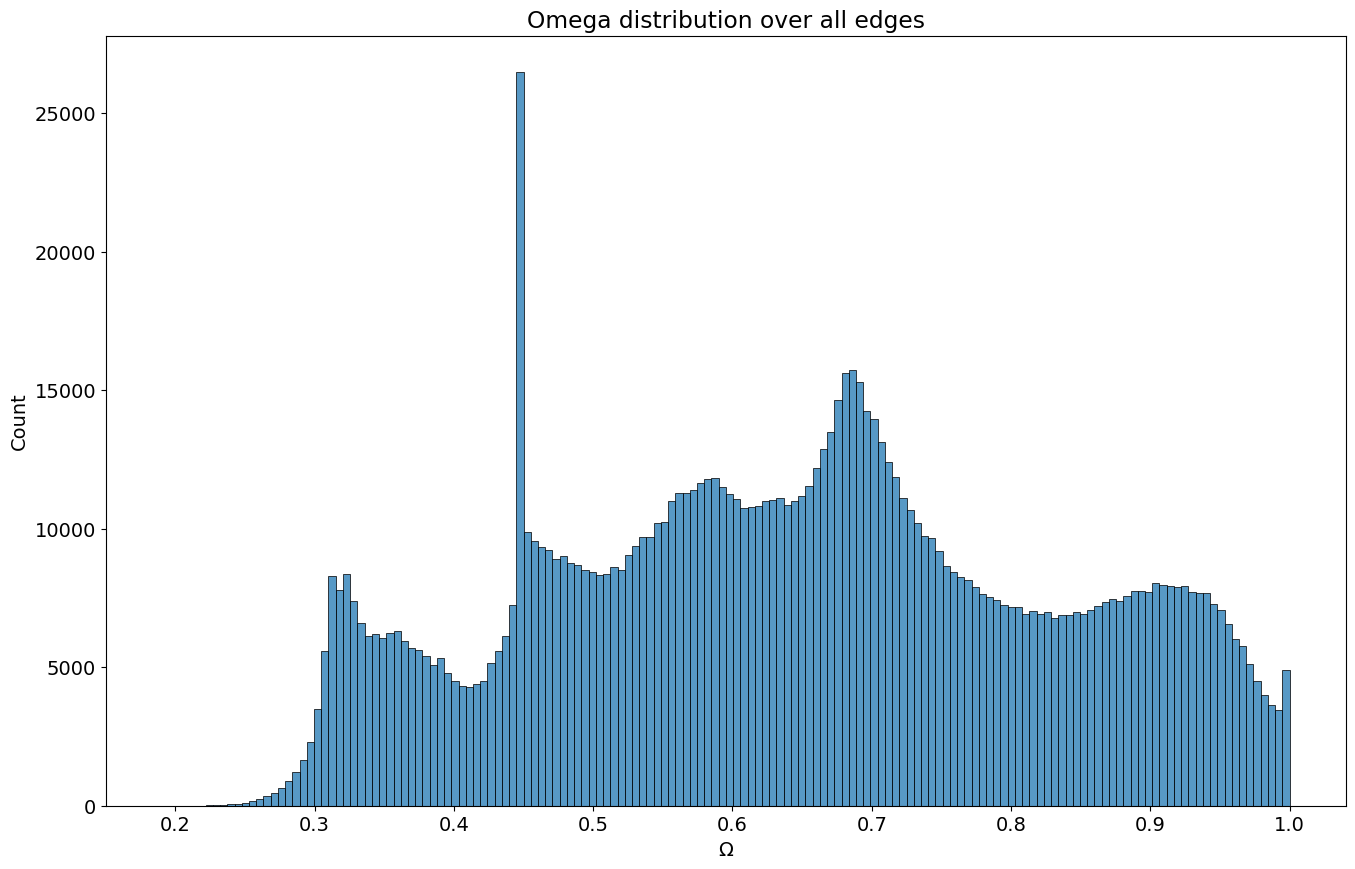

In [57]:
plt.rcParams['font.size'] = '14'
plt.figure(figsize=(16, 10))

sns.histplot(
    edges_omega_df['omega_pred'])

plt.xlabel('$\Omega$')
plt.title('Omega distribution over all edges')
plt.savefig(f'reports/images/{dataset_name}/structural_mlp/best_omega_distribution.png')

In [58]:
metrics = {
    'ROC AUC - All edges': [roc_auc_score(theta, preds)],
    'Mean': [edges_omega_df['omega_pred'].mean()],
    'Std. Dev.': [edges_omega_df['omega_pred'].std()],
    'Skewness': [edges_omega_df['omega_pred'].skew()],
    'Kurtosis': [edges_omega_df['omega_pred'].kurt()],
}

print(pd.DataFrame(metrics).round(3).style.to_latex())

\begin{tabular}{lrrrrr}
 & ROC AUC - All edges & Mean & Std. Dev. & Skewness & Kurtosis \\
0 & 0.742000 & 0.645000 & 0.181000 & 0.002000 & -0.871000 \\
\end{tabular}

